# Optimal Transport for Image Processing 

**Author:** Tran Thu Le

**Date:** 1/2/2023

## Optimal Transport problem

The Optimal transport is a linear programming problem:

$$\begin{aligned}
\min_{P \in \mathbb R^{n \times n}} \hspace{0.5cm} & \sum_{i,j} C_{ij}P_{ij}\\
s.t. \hspace{0.5cm} & P_{ij}\geq 0, \forall i, j =1,..., n\\
    & \sum_j P_{ij} = a_i, \forall i=1,...,n\\
     & \sum_i P_{ij} = b_j, \forall j=1,...,n
\end{aligned}\tag{OT}$$

Here $a$ is the vector of resources, $b$ is the vector of targets, $C_{ij}$ is the cost of moving a unit resource from $a_i$ to $b_j$. The solution $P$ is the matrix plan, where $P_{ij}$ is the amount of resource moving from $a_i$ to $b_j$. In pratice, $C$ is the distance matrix, i.e.
$$C_{ij} = ||x^{(1)}_i-x^{(2)}_j||_2$$

Here $x^{(1)}, x^{(2)}\in \mathbb R^{n\times 2}$ are the locations of resources $a$ and targets $b$, respectively.

![](https://media.springernature.com/lw685/springer-static/image/chp%3A10.1007%2F978-3-030-72437-5_13/MediaObjects/498075_1_En_13_Fig1_HTML.png )

However, the solution of OT problem is not a vector but a matrix. From programming point of view, solving this problem requires the task of reshaping the matrix $P$ into an array of dimension 1 and rewrite all the contraints in terms of the new array. This formulation becomes too complicated.

Since this is a popular problem, many packages in Python provide the tool to solve this problem in a single line of code.

For example, we can use `POT` package, which solve the problem using the following commands.

```python
import ot
P = ot.emd(a, b, C)
```


Note that you can install this package by executing the following code:

In [242]:
!pip install POT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In the next section we will apply the Optimal transport to **Image interpolation problem** in Image Processing.

# Image Processing - Image interpolation

## Prepare images

Make sure that you have the images `heart.png` and `duck.png` in the same folder to this notebook. The images can be downloaded in my [github](https://github.com/Tran-Thu-Le/pyopt), see folder `optimal_transport`.

Here the variables `x1` ($x^{(1)}$) and `x2` ($x^{(2)}$) are the locations of resource and target points, respectively.

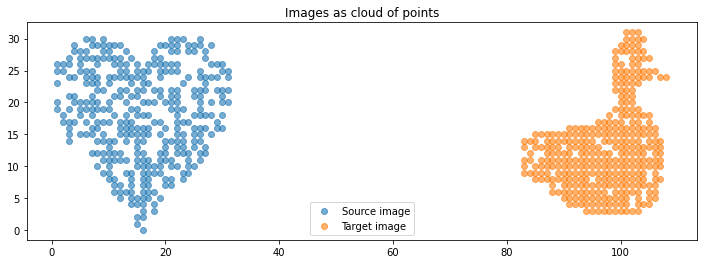

In [243]:
import numpy as np 
import matplotlib.pyplot as plt 
import ot
import matplotlib.animation as animation
from IPython import display

N = 2
d = 2

I1 = plt.imread('./heart.png').astype(np.float64)[::4, ::4, 2]
I2 = plt.imread('./duck.png').astype(np.float64)[::4, ::4, 2]
I1 = np.flip(I1, axis=0)

sz = I2.shape[0]
XX, YY = np.meshgrid(np.arange(sz), np.arange(sz))

x1 = np.stack((XX[I1 == 0], YY[I1 == 0]), 1) * 1.0
x2 = np.stack((XX[I2 == 0] + 80, -YY[I2 == 0] + 32), 1) * 1.0

n = int(0.9*min(x1.shape[0], x2.shape[0]))
x1_rand_positions = np.random.choice(range(x1.shape[0]), n,replace=False)
x1 = x1[x1_rand_positions, :]
x2_rand_positions = np.random.choice(range(x2.shape[0]), n, replace=False)
x2 = x2[x2_rand_positions, :]

measures_locations = [x1, x2]
measures_weights = [ot.unif(x1.shape[0]), ot.unif(x2.shape[0])]

plt.figure(1, (12, 4))
plt.scatter(x1[:, 0], x1[:, 1], alpha=0.6, label='Source image')
plt.scatter(x2[:, 0], x2[:, 1], alpha=0.6, label='Target image')
plt.title('Images as cloud of points')
plt.legend()
plt.show()

## Solving Optimal Transport Problem

We now set the weights `a` of `x1` and `b` of `x2` are uniform. We then solve OT problem using `ot.emd()` function. Here `emd` means *Earth Movers Distance problem*. The (normalized) optimal matrix `G0` is displayed.

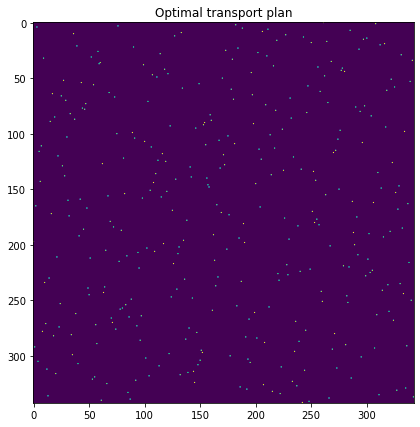

In [244]:
a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples x1, x2
# loss matrix
M = ot.dist(x1, x2)

# solve optimal transport problem
G0 = ot.emd(a, b, M)


plt.figure(2, (7, 7))
plt.imshow(G0)
plt.title("Optimal transport plan")
plt.show()

## Optimal transport plan: A visualization

If `G0[i, j] !=0` then we draw a line connect $x^{(1)}_i$ and $x^{(2)}_j$.

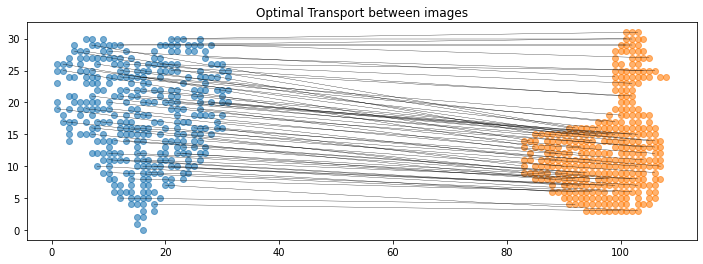

In [245]:
def get_pairs(G0):
    n = G0.shape[0]
    pairs = []
    for i in range(n):
        for j in range(n):
            if G0[i, j] !=0:
                pairs += [(i, j)]

    return pairs

def new_images_with_aranging_points(image_1, image_2):
    pairs = get_pairs(G0) 
    img1_indices = [p[0] for p in pairs]
    img2_indices = [p[1] for p in pairs]
    return image_1[img1_indices, :], image_2[img2_indices, :]

img1, img2 = new_images_with_aranging_points(x1, x2)

plt.figure(3, (12, 4))
plt.scatter(x1[:, 0], x1[:, 1], alpha=0.6)
plt.scatter(x2[:, 0], x2[:, 1], alpha=0.6)
for i in range(img1.shape[0]):
    if i%5==0:
        plt.plot([img1[i, 0], img2[i, 0]], [img1[i, 1], img2[i, 1]], c="k", lw=0.3)
plt.title('Optimal Transport between images')
plt.show()

## Interpolation between images: An animation

In [246]:
nb_iter_max = 10
times = np.linspace(0., 1., nb_iter_max).reshape(-1, 1, 1)
x_all = (1-times)* img1 + times* img2
fig, ax = plt.subplots(figsize=(12, 4))
def _update_plot(i):
    plt.clf()
    plt.scatter(x1[:, 0], x1[:, 1], alpha=0.5, color="blue")
    plt.scatter(x2[:, 0], x2[:, 1], alpha=0.5, color="orange")
    if i<= nb_iter_max//2:
        color = "blue"
    else:
        color = "orange"
    plt.scatter(x_all[i, :, 0], x_all[i, :, 1], c=color, alpha=0.3)
    plt.title(f"Image interpolation at time {round(float(times[i]), 2)}")
    # plt.axis(ax)
    return 1

# create animation
ani = animation.FuncAnimation(fig, _update_plot, nb_iter_max, interval=500)

# display animation
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()